# Exploratory Analysis
### week_03_03_2024 update: 
- Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
- Explore patterns in payments - how many people are dividing the bill or paying total? This is only applicable to the restaurants Cantina Volpi and Ferreiro Café.
- Find new KPIs that can be of interest to the restaurant - new KPIs that can go on a monthly report.

In [2]:
import warnings
# Ignore the warning about the version of SQLAlchemy
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable.*")

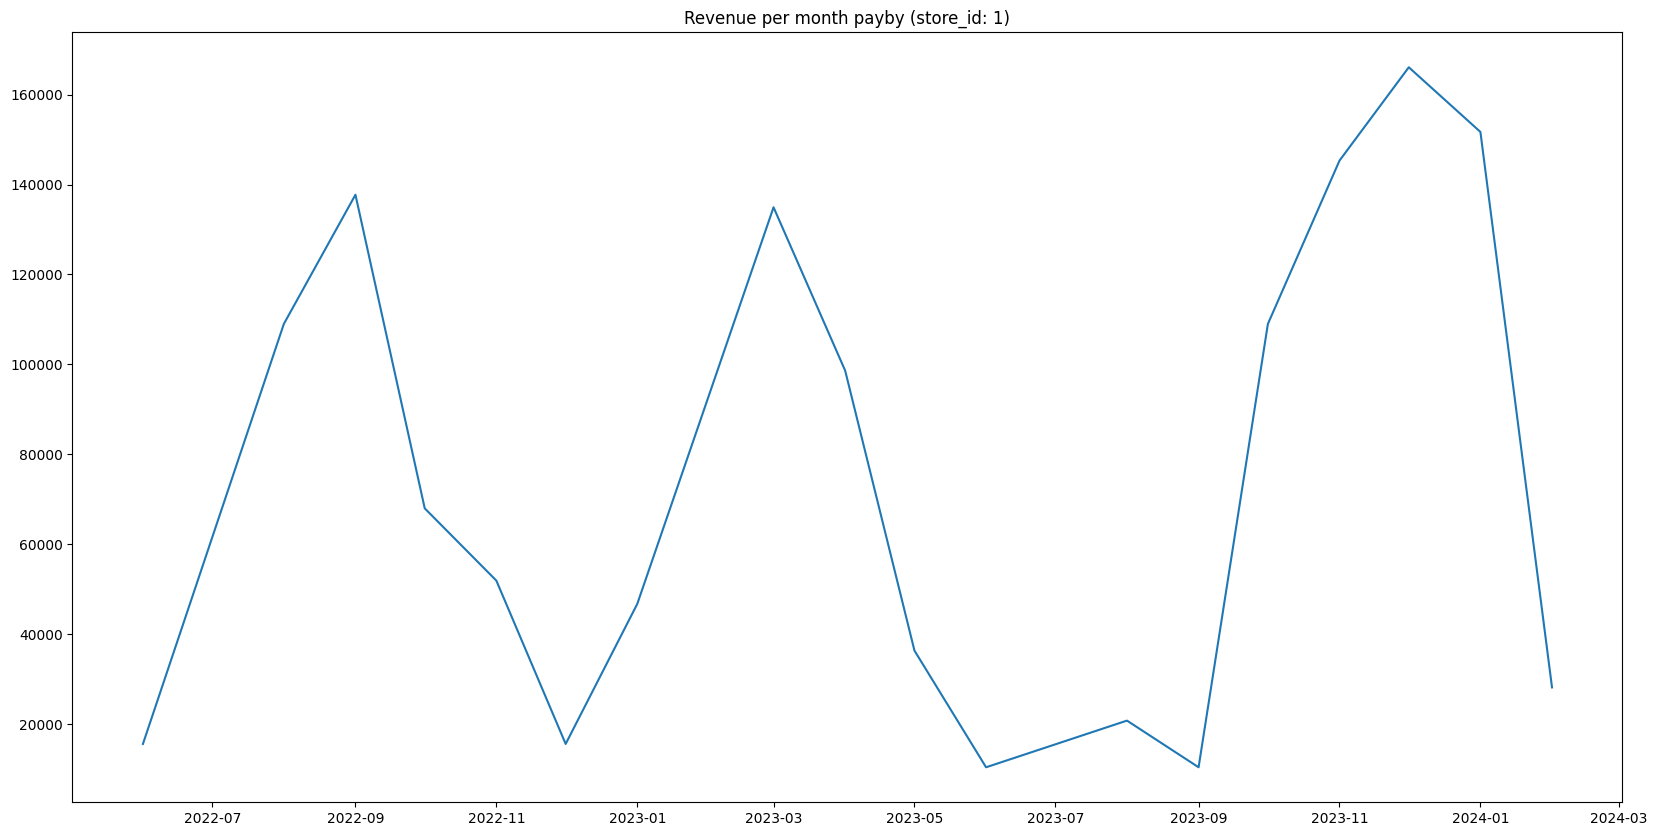

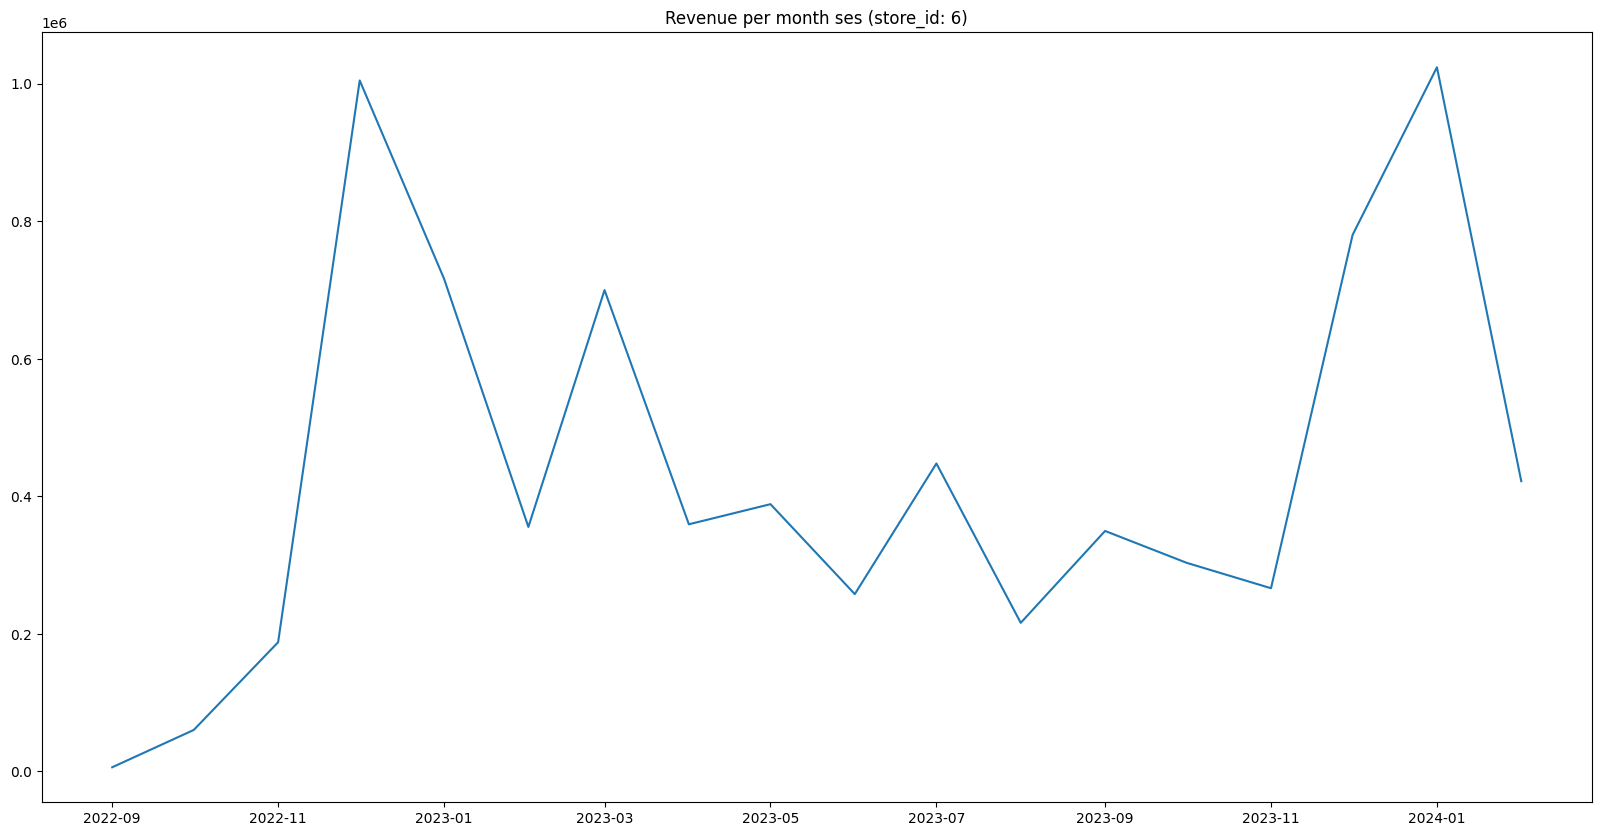

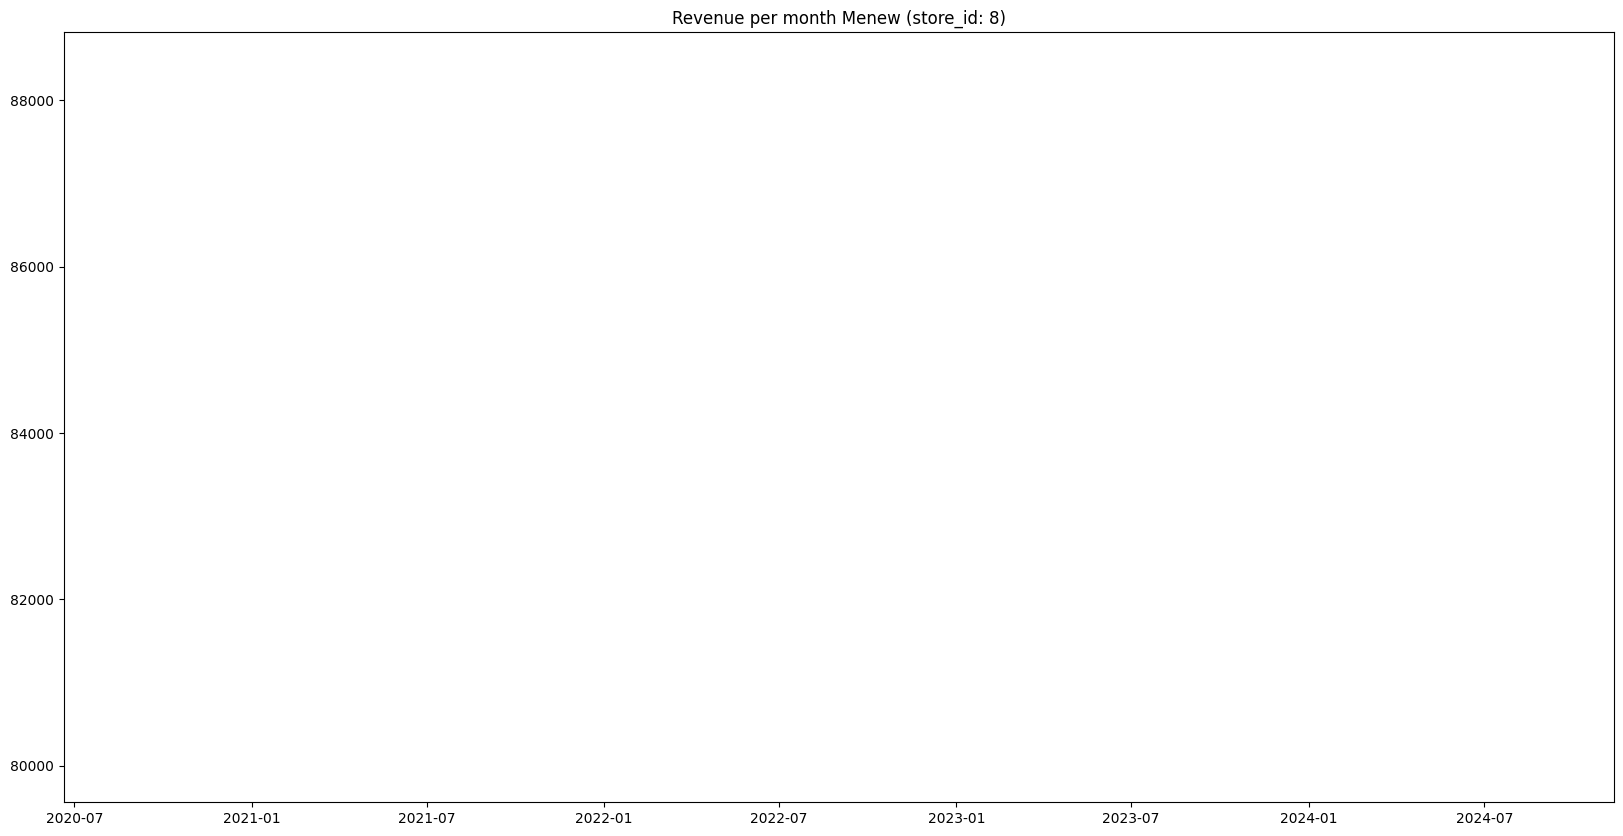

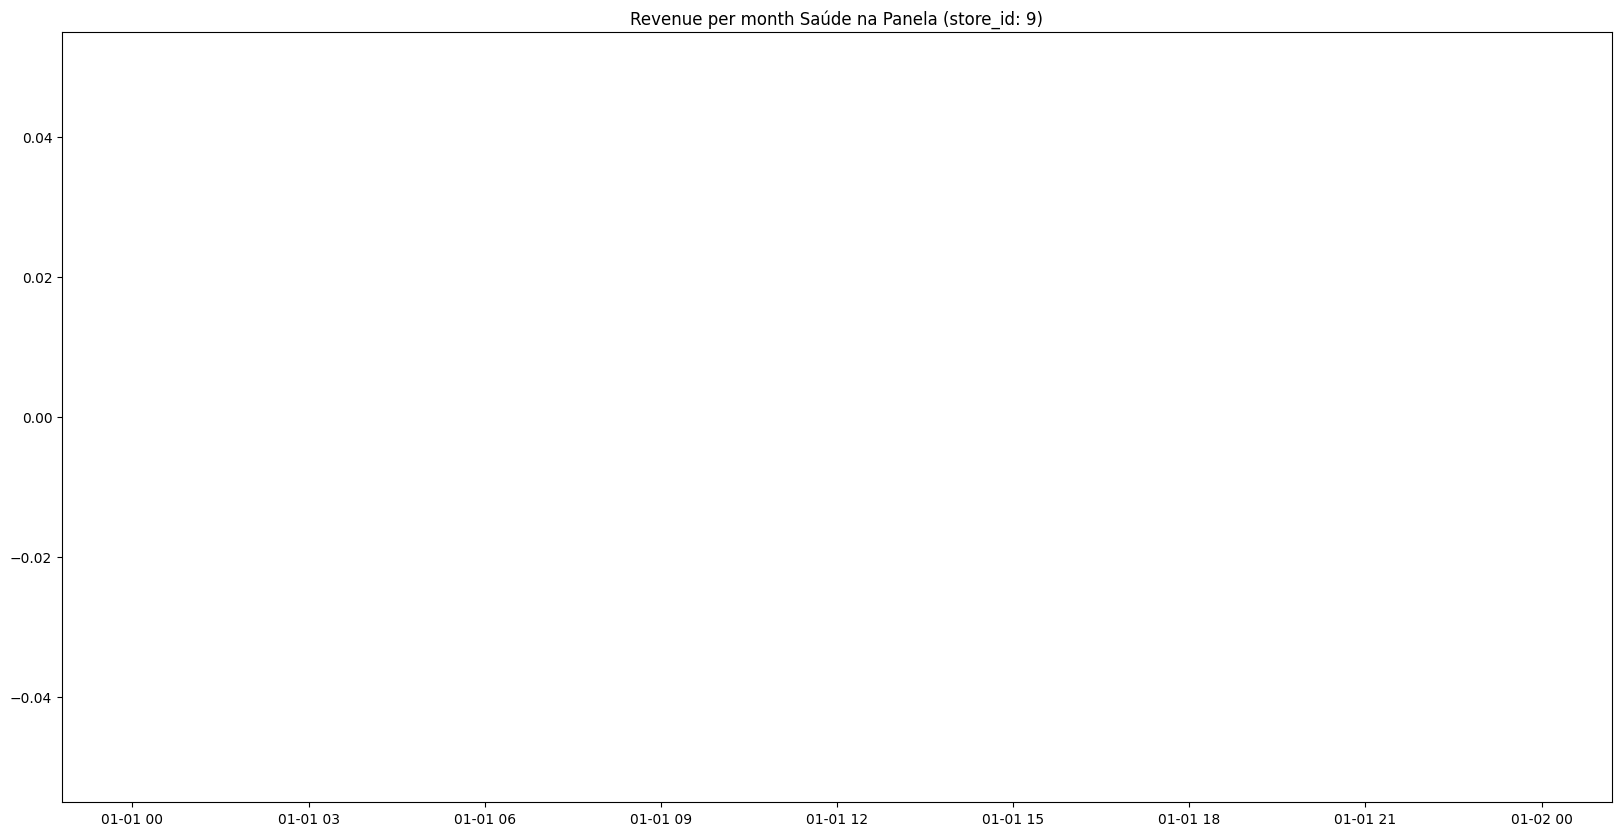

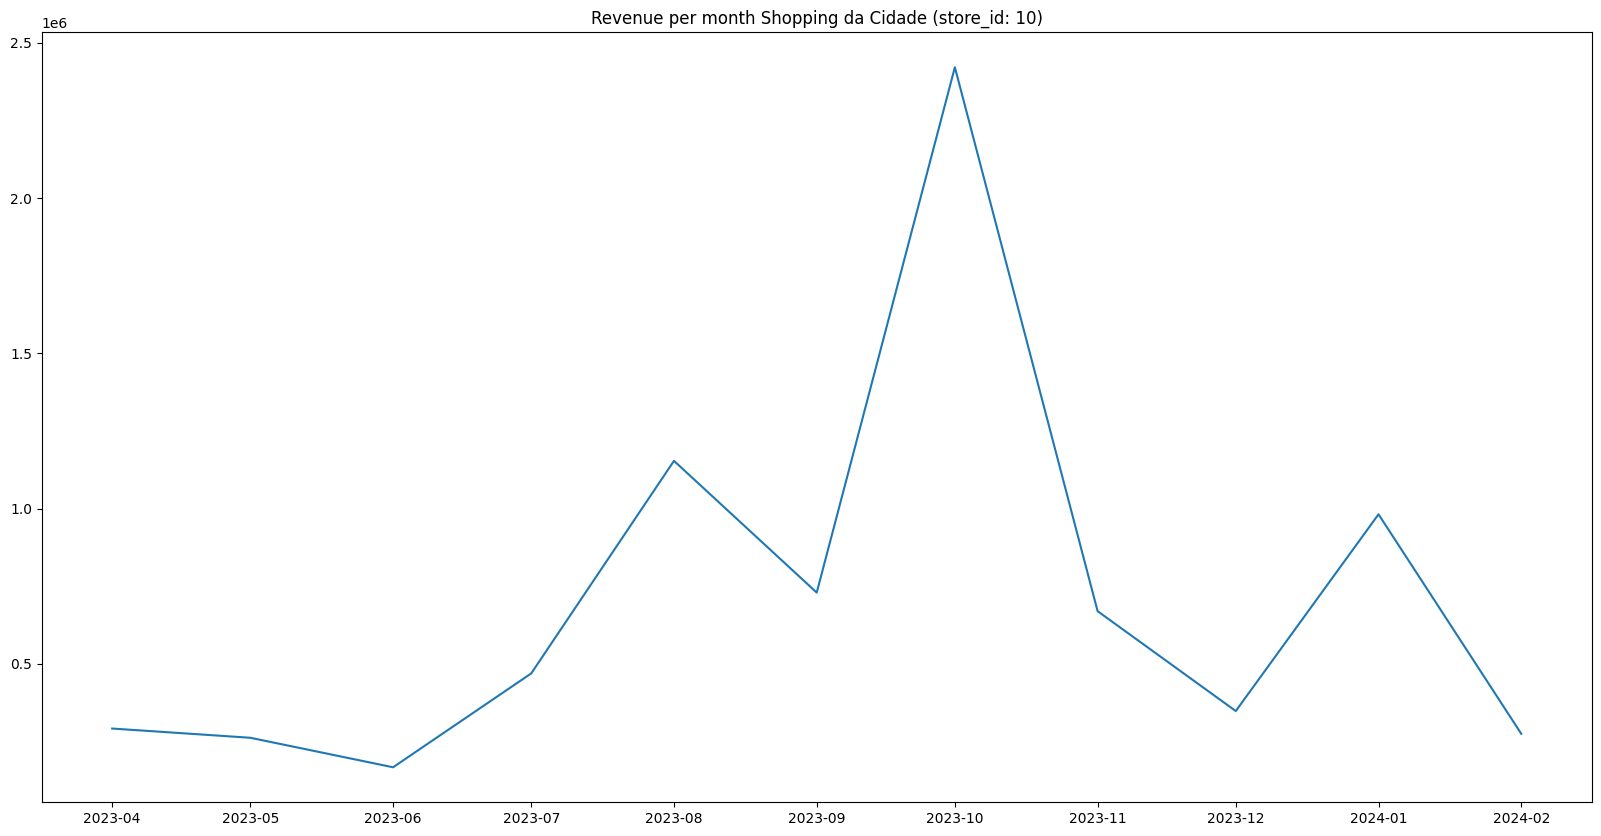

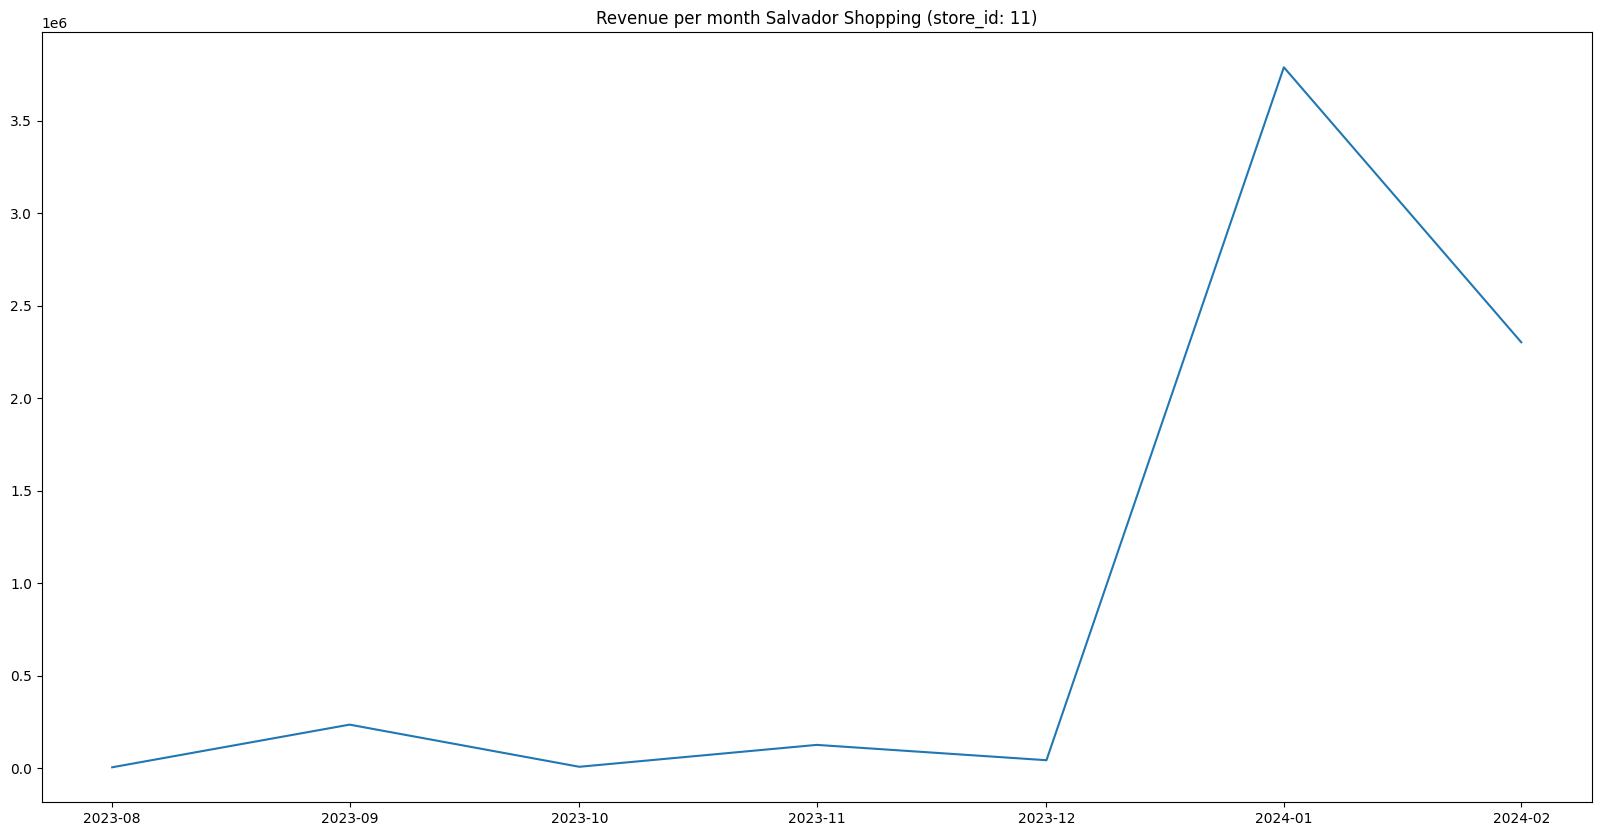

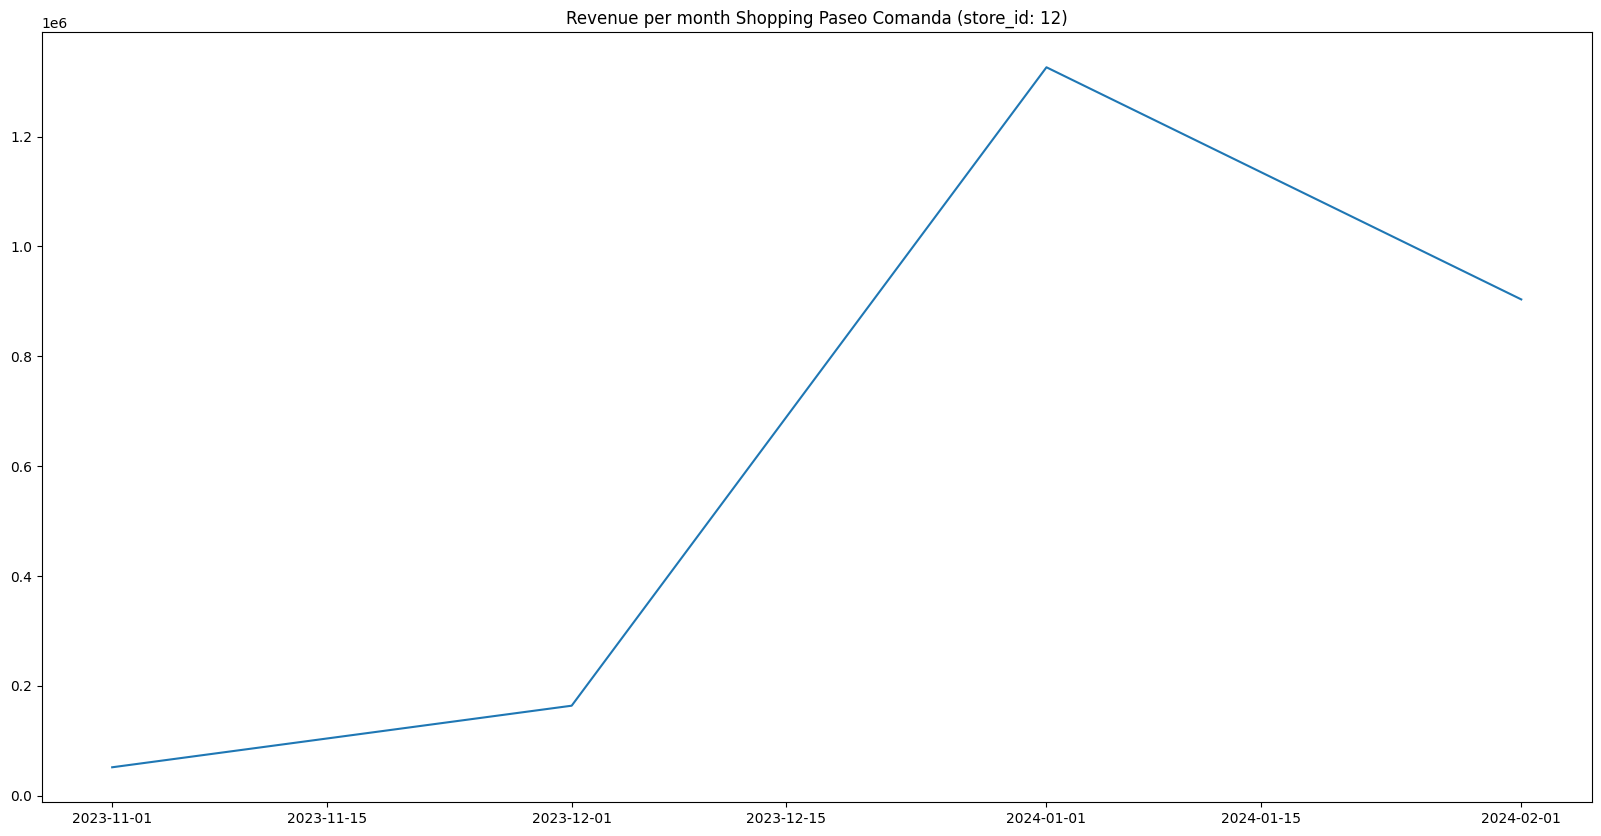

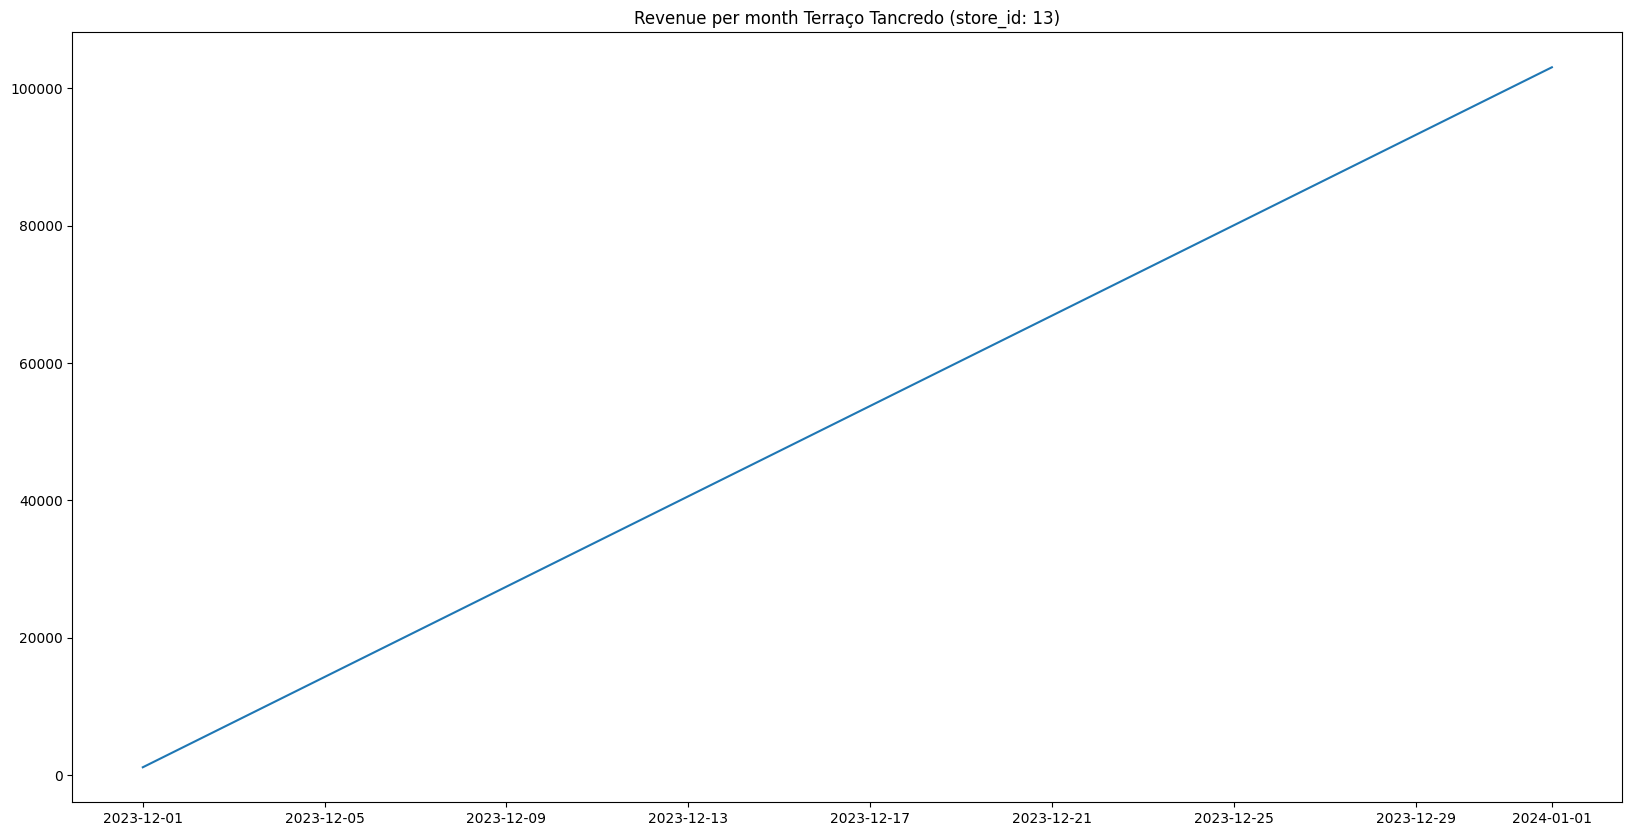

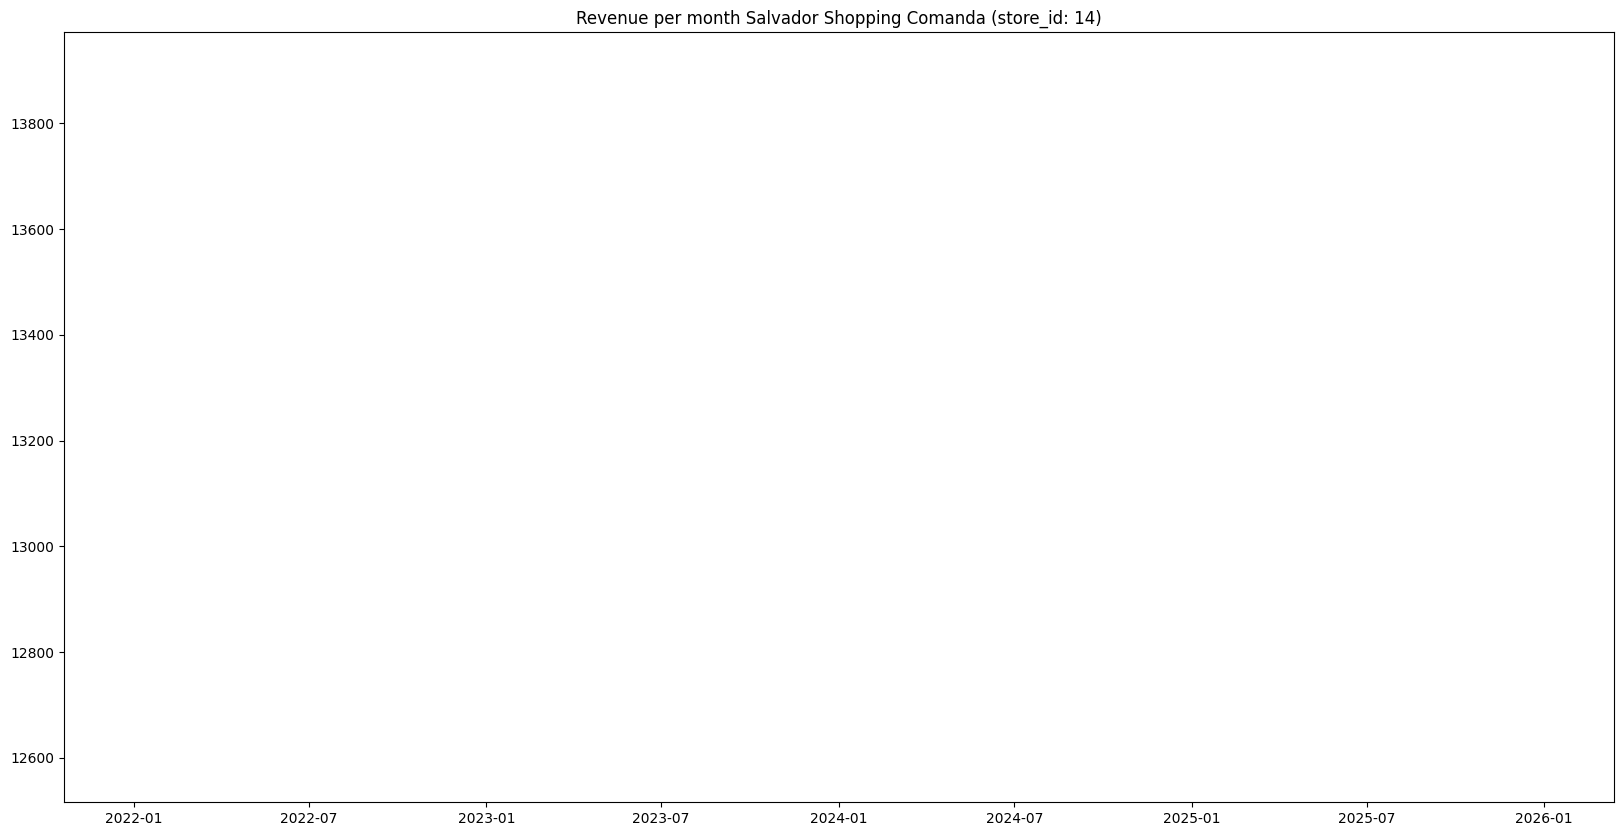

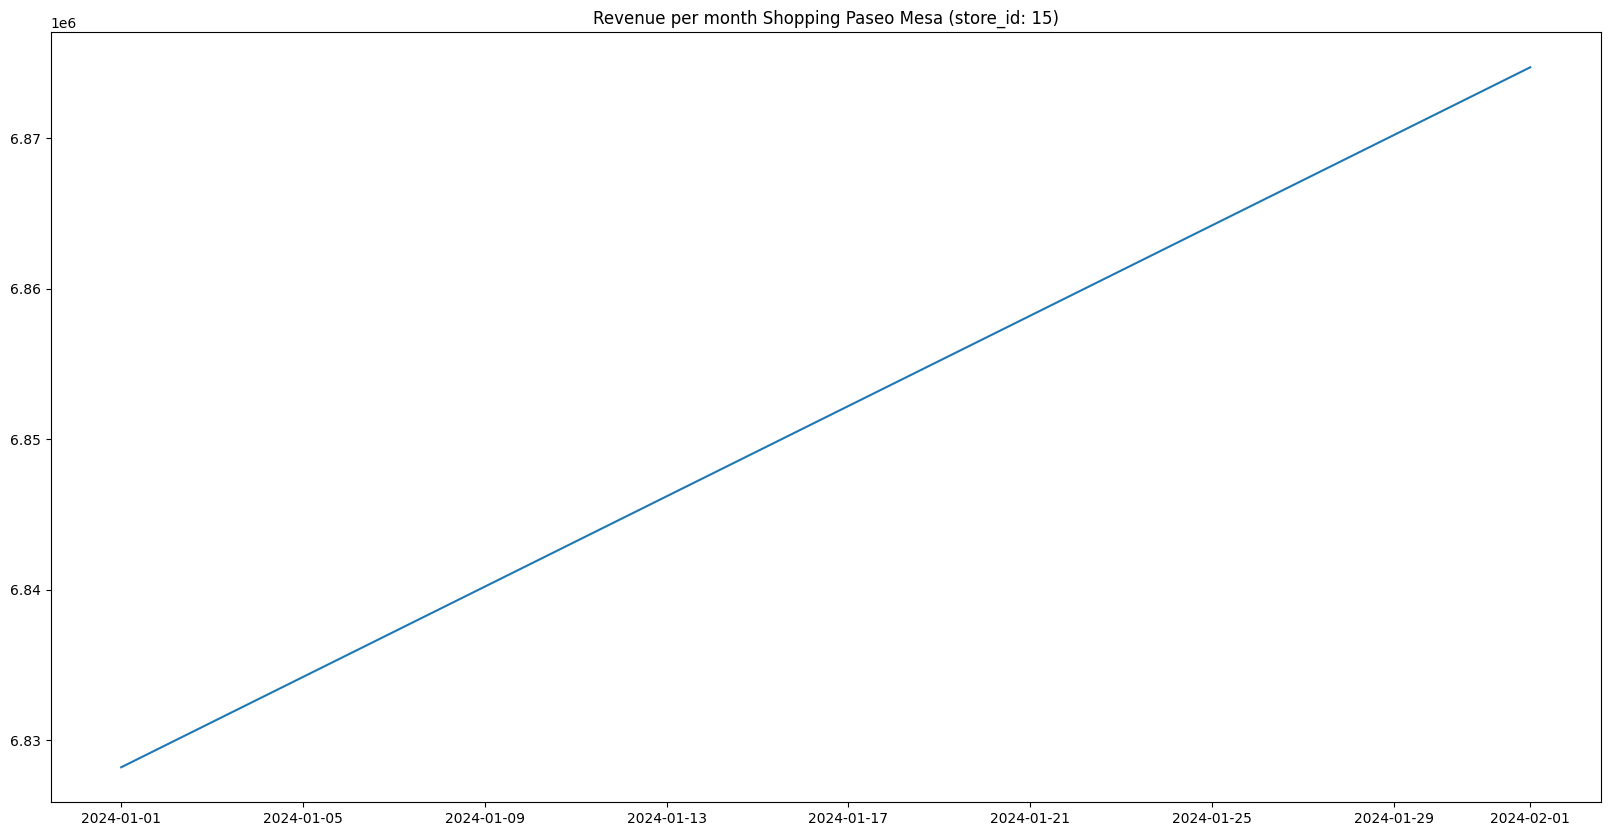

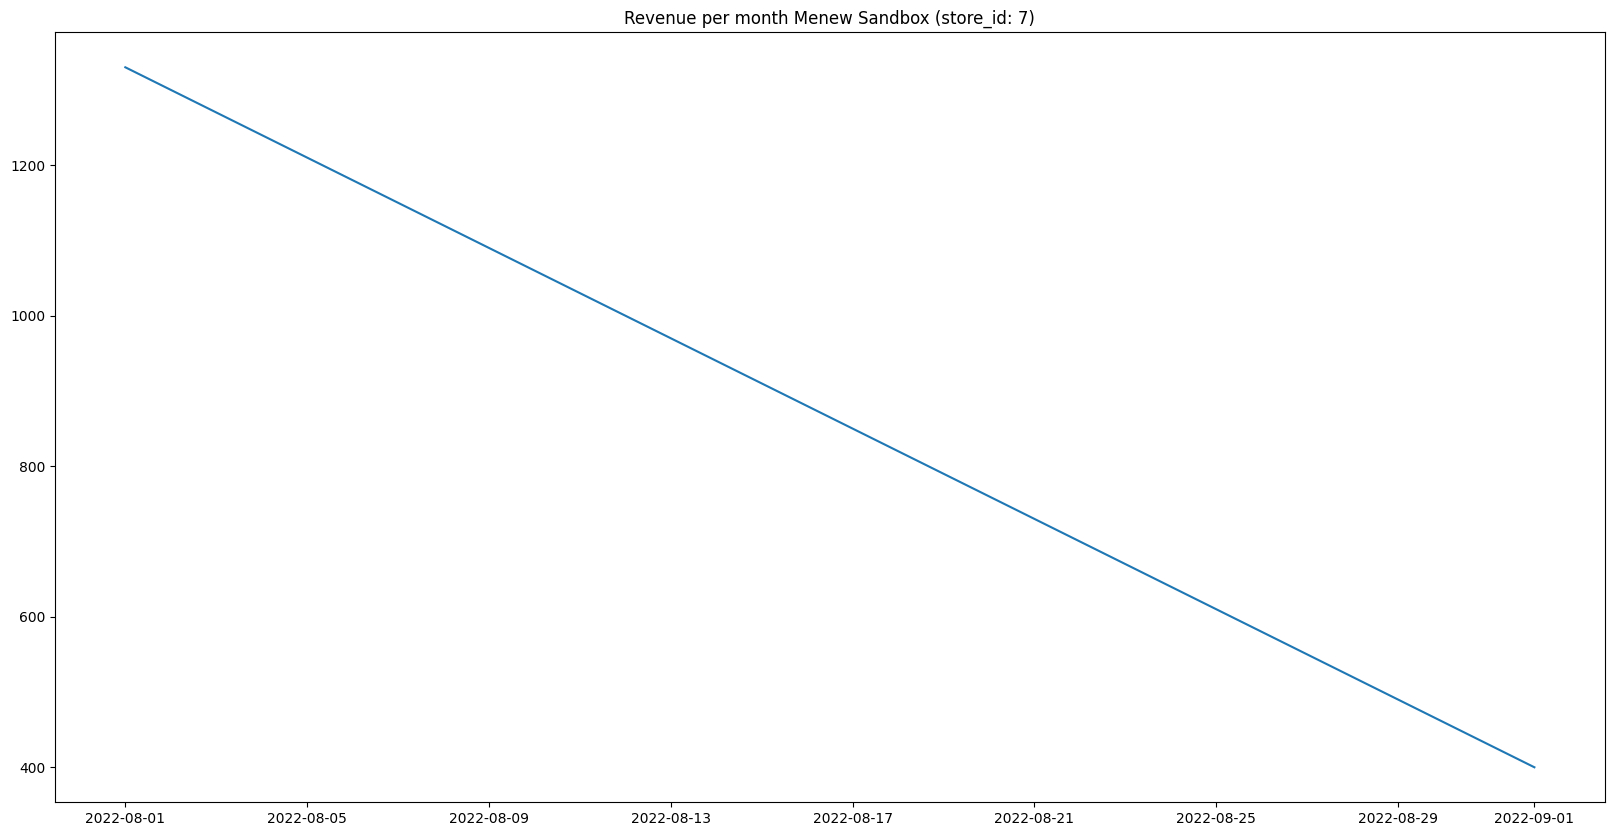

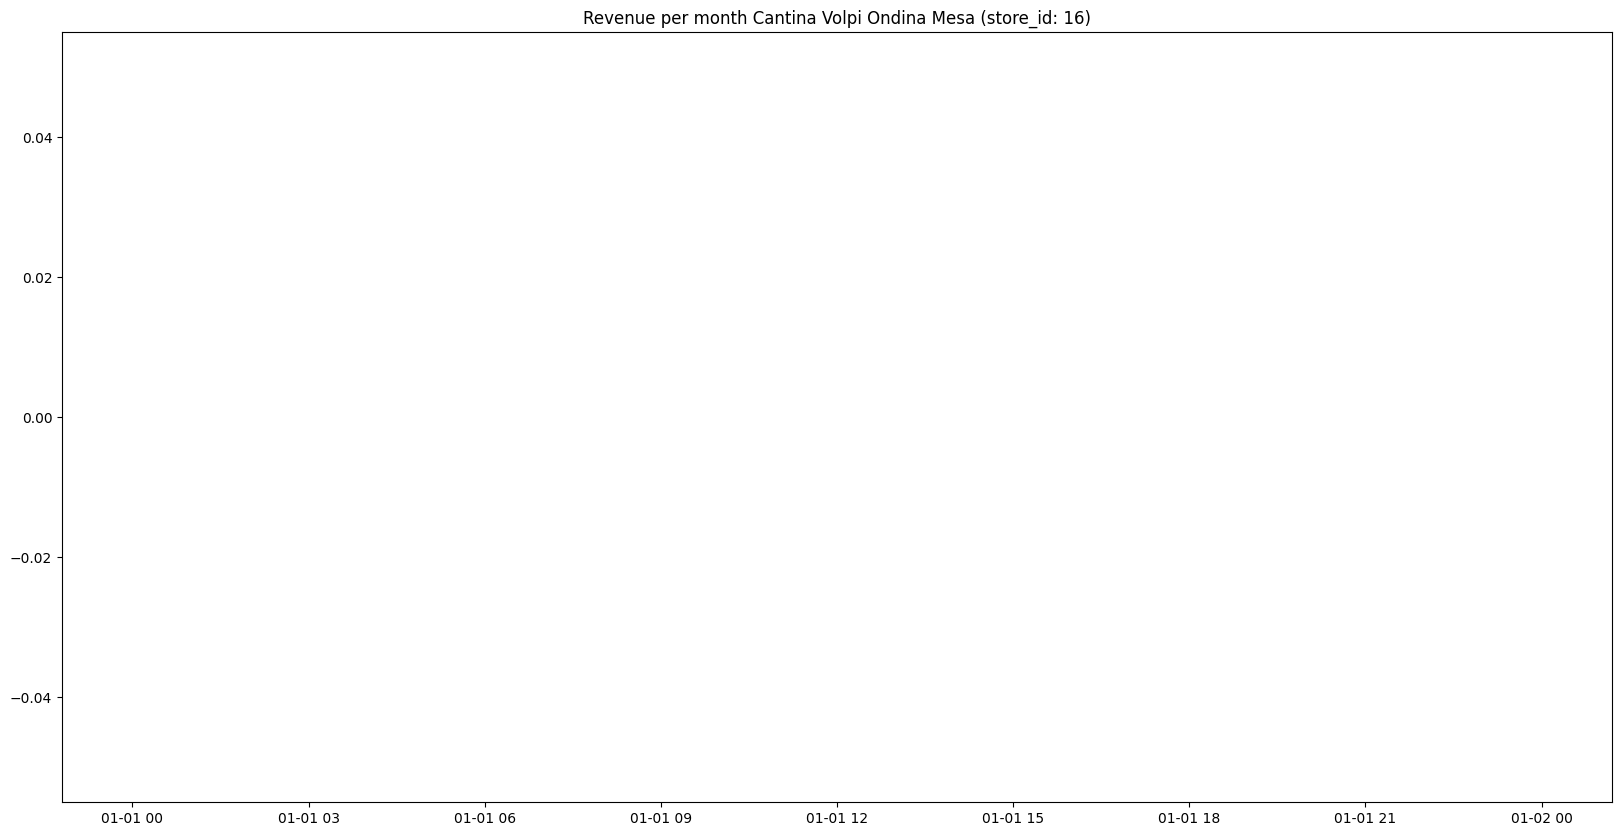

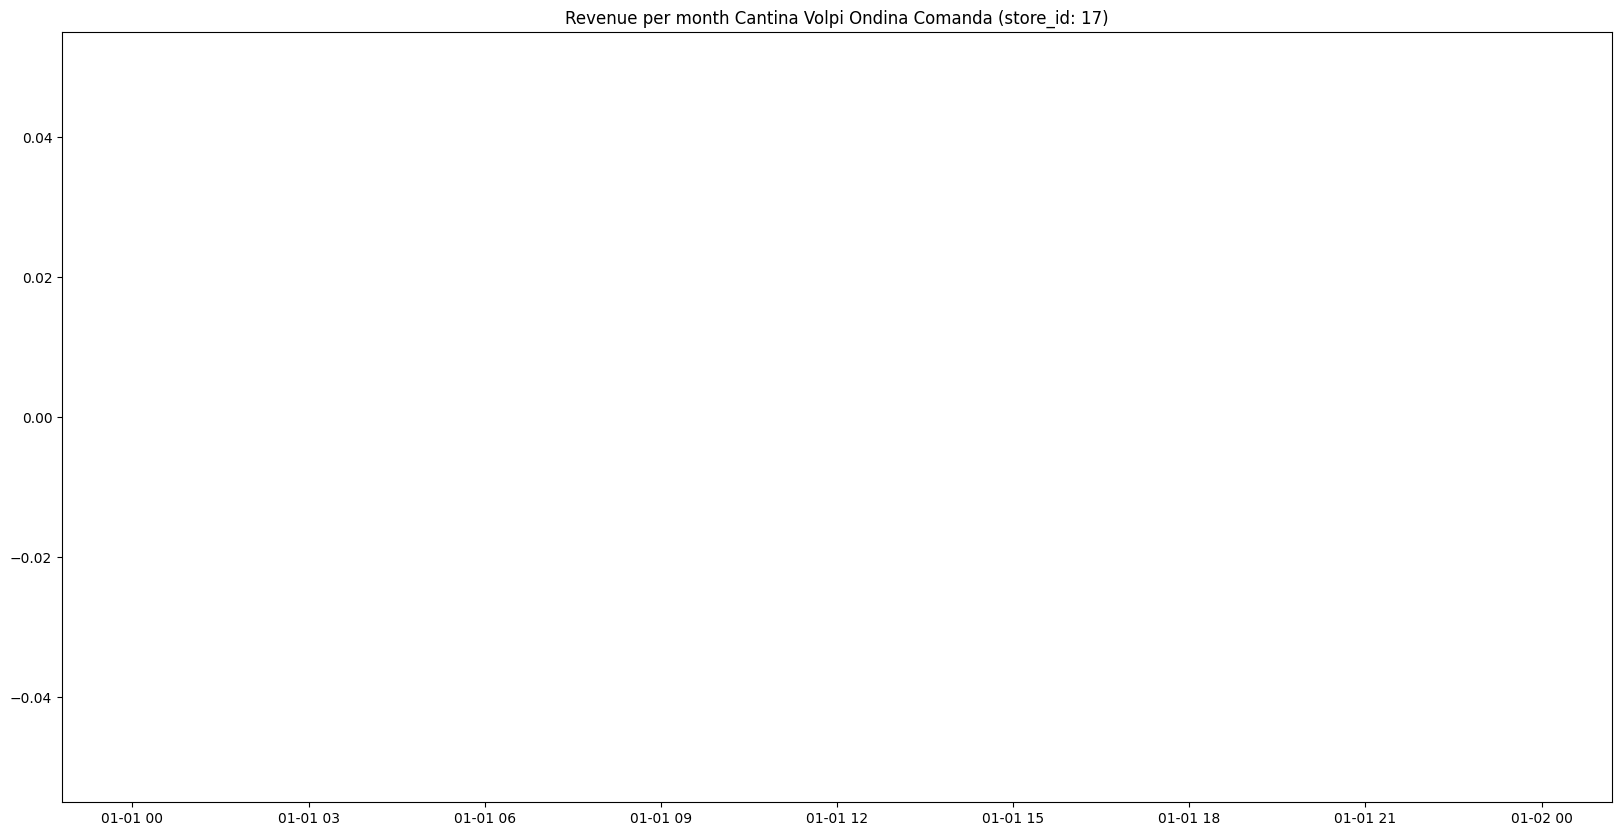

In [25]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
db_params = {
    'dbname': 'payby',
    'user': 'postgres',
    'password': '2458',
    'host': 'localhost',
    'port': '5432'
}
def get_all_store_ids():
    query = "SELECT id FROM core_store;"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_ids = cur.fetchall()
        store_ids = [store_id[0] for store_id in store_ids]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_ids = []
    finally:
        cur.close()
        conn.close()
    return store_ids

def get_store_name(store_id):
    query = f"SELECT name FROM core_store WHERE id = {store_id};"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_name = cur.fetchone()[0]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_name = None
    finally:
        cur.close()
        conn.close()
    return store_name

# Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
def get_revenue_per_month(store_id):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    cur.execute(f"""
        SELECT 
            EXTRACT(MONTH FROM dt_created) AS month,
            EXTRACT(YEAR FROM dt_created) AS year,
            SUM(table_total) AS revenue
        FROM 
            core_ticket
        WHERE 
            store_id = {store_id}
        GROUP BY 
            month, year
        ORDER BY 
            year, month
    """)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def get_revenue_per_month_multi(store_id_list):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    query = f"""
        SELECT 
            EXTRACT(MONTH FROM dt_created) AS month,
            EXTRACT(YEAR FROM dt_created) AS year,
            SUM(table_total) AS revenue
        FROM 
            core_ticket
        WHERE 
            store_id IN ({','.join([str(store_id) for store_id in store_id_list])})
        GROUP BY 
            month, year
        ORDER BY 
            year, month
    """
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def average_revenue_per_month(results):
    total_revenue = sum([result[2] for result in results])
    if len(results) == 0: return 0
    average_revenue = total_revenue / len(results)
    return average_revenue

store_ids = get_all_store_ids()
for store_id in store_ids:
    store_name = get_store_name(store_id)
    revenue = get_revenue_per_month(store_id)
    df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.sort_values('date')

    plt.figure(figsize=(20, 10))
    plt.title(f"Revenue per month {store_name} (store_id: {store_id})")
    plt.plot(df['date'], df['revenue'])
    plt.show()


# intersted_store_ids = [[12, 15], [11, 14]]
# for store_id in intersted_store_ids:
#     store_name = get_store_name(store_id[0])
#     revenue = get_revenue_per_month_multi(store_id)
#     df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
#     df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
#     df = df.sort_values('date')
    
#     plt.figure(figsize=(20, 10))
#     plt.title(f"Revenue per month {store_name} (store_id: {store_id})")  
#     plt.plot(df['date'], df['revenue'])
#     plt.show()

#     print(f"Average revenue per month for {store_name}: {average_revenue_per_month(revenue):.2f}")

-------------------------- No change from last time --------------------------

### Best Day for store_id = [12, 15, 11, 14]

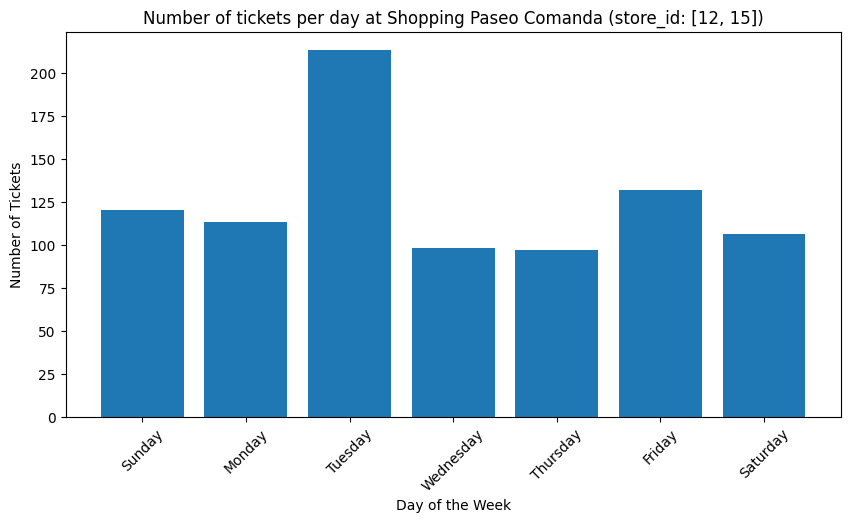

The best day to visit Shopping Paseo Comanda (store_id: [12, 15]) is Tuesday.


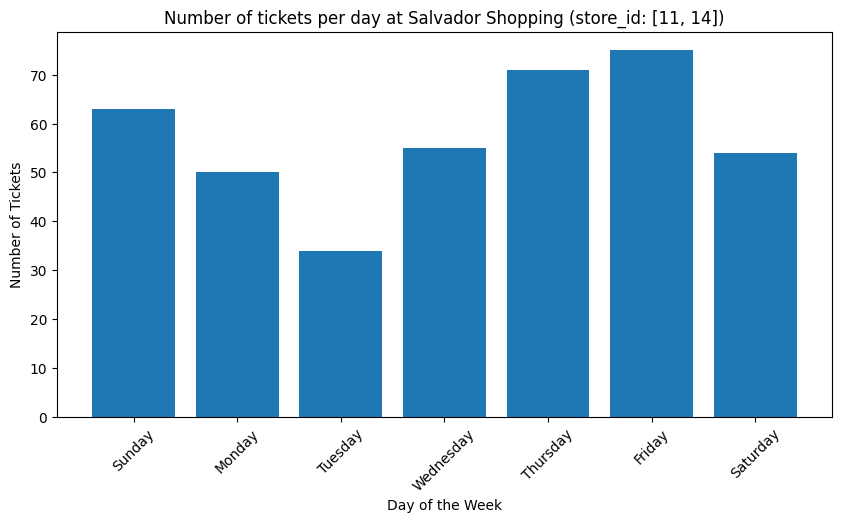

The best day to visit Salvador Shopping (store_id: [11, 14]) is Friday.


In [15]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# get the total number of tickets per day of the week
def get_tickets_per_day(store_id):
    query = f"""
    SELECT EXTRACT(DOW FROM dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket
    WHERE store_id = {store_id}
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def get_tickets_per_day_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_tickets_per_day(store_id_list[0])
    query = f"""
    SELECT EXTRACT(DOW FROM dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket
    WHERE store_id IN {tuple(store_id_list)}
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
def get_best_day_to_visit(df):
    df['day_name'] = df['day_of_week'].map(day_names)
    best_day = df[df['count'] == df['count'].max()]['day_name'].values[0]
    return best_day

def plot_tickets_per_day(df, store_name, store_id):
    df['day_name'] = df['day_of_week'].map(day_names)
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['day_name'], df['count'], align='center')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per day at {store_name} (store_id: {store_id})')
    plt.xticks(rotation=45)
    plt.show()

#intersted_store_ids = get_all_store_ids()
#intersted_store_ids = [[12], [15], [11], [14]]
intersted_store_ids = [[12, 15], [11, 14]]

for store_id in intersted_store_ids:
    df = get_tickets_per_day_multi(store_id)
    if not df.empty:
        best_day = get_best_day_to_visit(df)
        store_name = get_store_name(store_id[0])
        plot_tickets_per_day(df, store_name, store_id)
        print(f"The best day to visit {store_name} (store_id: {store_id}) is {best_day}.")
    else:
        print(f"No tickets found for store_id: {store_id}.")


### Busiest Times for store_id = [12, 15, 11, 14]

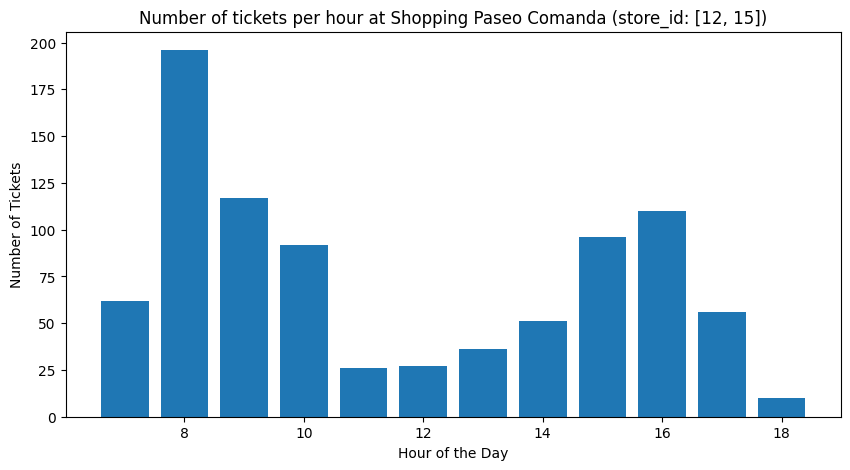

The busiest hour at Shopping Paseo Comanda (store_id: [12, 15]) is 8:00.


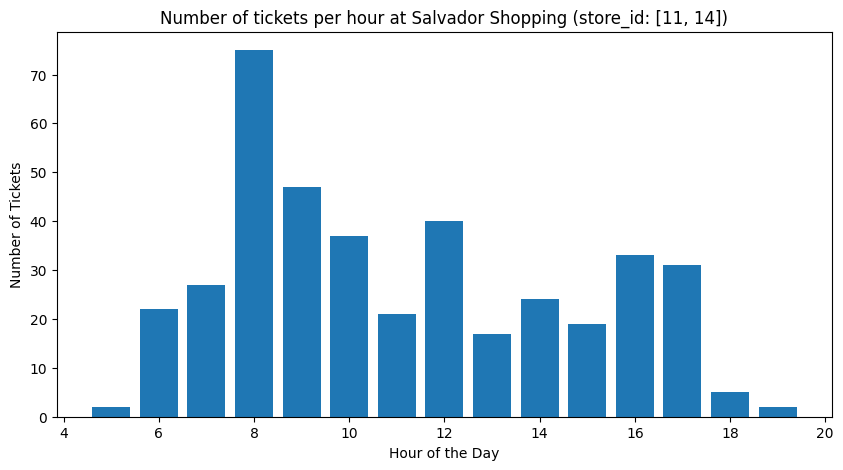

The busiest hour at Salvador Shopping (store_id: [11, 14]) is 8:00.


In [16]:
# print the ts_created column of the core_ticket table
def get_ticket_creation_times(store_id):
    query = f'''SELECT EXTRACT(HOUR FROM ts_created) AS hour, COUNT(*) 
    AS count FROM core_ticket 
    WHERE store_id = {store_id} 
    GROUP BY hour ORDER BY hour;
    '''
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df
def get_ticket_creation_times_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_ticket_creation_times(store_id_list[0])
    query = f'''SELECT EXTRACT(HOUR FROM ts_created) AS hour, COUNT(*) 
    AS count FROM core_ticket 
    WHERE store_id IN {tuple(store_id_list)} 
    GROUP BY hour ORDER BY hour;
    '''
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def plot_tickets_per_hour(df, store_name, store_id):
    plt.figure(figsize=(10, 5))
    plt.bar(df['hour'], df['count'], align='center')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per hour at {store_name} (store_id: {store_id})')
    plt.show()

#intersted_store_ids = get_all_store_ids()
#intersted_store_ids = [12, 15, 11, 14]
intersted_store_ids = [[12, 15], [11, 14]]
# plot the number of tickets created per hour
# and print the buiziets hour of the day
for store_id in intersted_store_ids:
    df = get_ticket_creation_times_multi(store_id)
    if not df.empty:
        busiest_hour = df[df['count'] == df['count'].max()]['hour'].values[0]
        store_name = get_store_name(store_id[0])
        plot_tickets_per_hour(df, store_name, store_id)
        print(f"The busiest hour at {store_name} (store_id: {store_id}) is {int(busiest_hour)}:00.")
    else:
        print(f"No tickets found for store_id: {store_id}.")
